In [1]:
import sys
from pathlib import Path

# path_to_your_local_folder = Path("/Users/marco/Work-MBP/gtfs_railways")
path_to_your_local_folder = Path("C:/Users/KIIT/Documents/UAntwerp/railways_resilience")
sys.path.append(str(path_to_your_local_folder))

from utils.imports import *

Loading BokehJS ...

In [2]:
from config import PATH_TO_SQLITE
attributes = load_gtfs(str(PATH_TO_SQLITE))
L_graph = load_graph(L_SPACE_PATH)
# L_graph=load_graph(DATA_DIR / "pkl/nl_merged.pkl")

## Nodes

In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- Load graphs explicitly ---
L_graph_BE = load_graph(L_SPACE_PATH)
L_graph_NL = load_graph(DATA_DIR / "pkl/nl_merged.pkl")

def compute_connectivity_metrics(df, G):
    """
    Compute SCC, WCC, largest SCC, and largest WCC as nodes are progressively edge-removed.
    G: directed graph (copy will be made internally)
    """
    G = G.copy()  # single copy per run
    N = G.number_of_nodes()

    num_scc = []
    num_wcc = []
    largest_scc_norm = []
    largest_wcc_norm = []

    for _, row in df.iterrows():

        # SCC and WCC counts BEFORE removal
        num_scc.append(nx.number_strongly_connected_components(G))
        num_wcc.append(nx.number_weakly_connected_components(G))

        # Largest SCC
        sccs = nx.strongly_connected_components(G)
        largest_scc = max((len(c) for c in sccs), default=0)
        largest_scc_norm.append(largest_scc / N)

        # Largest WCC
        wccs = nx.weakly_connected_components(G)
        largest_wcc = max((len(c) for c in wccs), default=0)
        largest_wcc_norm.append(largest_wcc / N)

        # Remove edges of node (keep the node)
        node = row['removed_node']
        if pd.notna(node):
            node = int(node)
            if node in G:
                G.remove_edges_from(list(G.out_edges(node)))
                G.remove_edges_from(list(G.in_edges(node)))

    # Store results in DataFrame
    df['num_strong_components'] = num_scc
    df['num_weak_components'] = num_wcc
    df['largest_scc_normalized'] = largest_scc_norm
    df['largest_wcc_normalized'] = largest_wcc_norm

    return df


def plot_efficiency_comparison_single(run_configs, title="Efficiency Comparison", xlim=None):
    """
    Plot normalized efficiency and connectivity metrics for multiple runs on the same figure.

    run_configs: list of dicts, each with keys:
        'fil'  -> path to CSV
        'color' -> line color
        'label' -> label for legend
    """
    plt.figure(figsize=(16, 14))

    metrics = [
        ('normalized_efficiency', 'Normalized Efficiency'),
        ('num_strong_components', 'Strong Components'),
        ('num_weak_components', 'Weak Components'),
        ('largest_scc_normalized', 'Largest SCC'),
        ('largest_wcc_normalized', 'Largest WCC')
    ]

    processed_runs = []

    for cfg in run_configs:
        df = load_removal_results_df(cfg['fil'])

        # Explicitly select the correct L_graph
        if cfg['label'] == 'Belgium':
            graph = L_graph_BE
        elif cfg['label'] == 'Netherlands':
            graph = L_graph_NL
        else:
            raise ValueError(f"Unknown label {cfg['label']}")

        df = compute_connectivity_metrics(df, graph)  # cumulative removal per run
        processed_runs.append((df, cfg['color'], cfg['label']))

    # --- Full width first plot: normalized efficiency ---
    plt.subplot(3, 2, (1, 2))
    col, ttl = metrics[0]
    for df, color, label in processed_runs:
        plt.plot(df['percent_remaining'], df[col], 'o-', linewidth=2, markersize=4, color=color, label=label)
    plt.title(ttl)
    plt.xlabel('Percent Remaining')
    plt.ylabel(ttl)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if xlim:
        plt.xlim(xlim)
    plt.gca().invert_xaxis()

    # --- Remaining 4 plots: connectivity metrics ---
    for i, (col, ttl) in enumerate(metrics[1:], start=3):
        plt.subplot(3, 2, i)
        for df, color, label in processed_runs:
            plt.plot(df['percent_remaining'], df[col], 'o-', linewidth=2, markersize=4, color=color, label=label)
        plt.title(ttl)
        plt.xlabel('Percent Remaining')
        plt.ylabel(ttl)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        if xlim:
            plt.xlim(xlim)
        plt.gca().invert_xaxis()

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()


### Targeted Removal

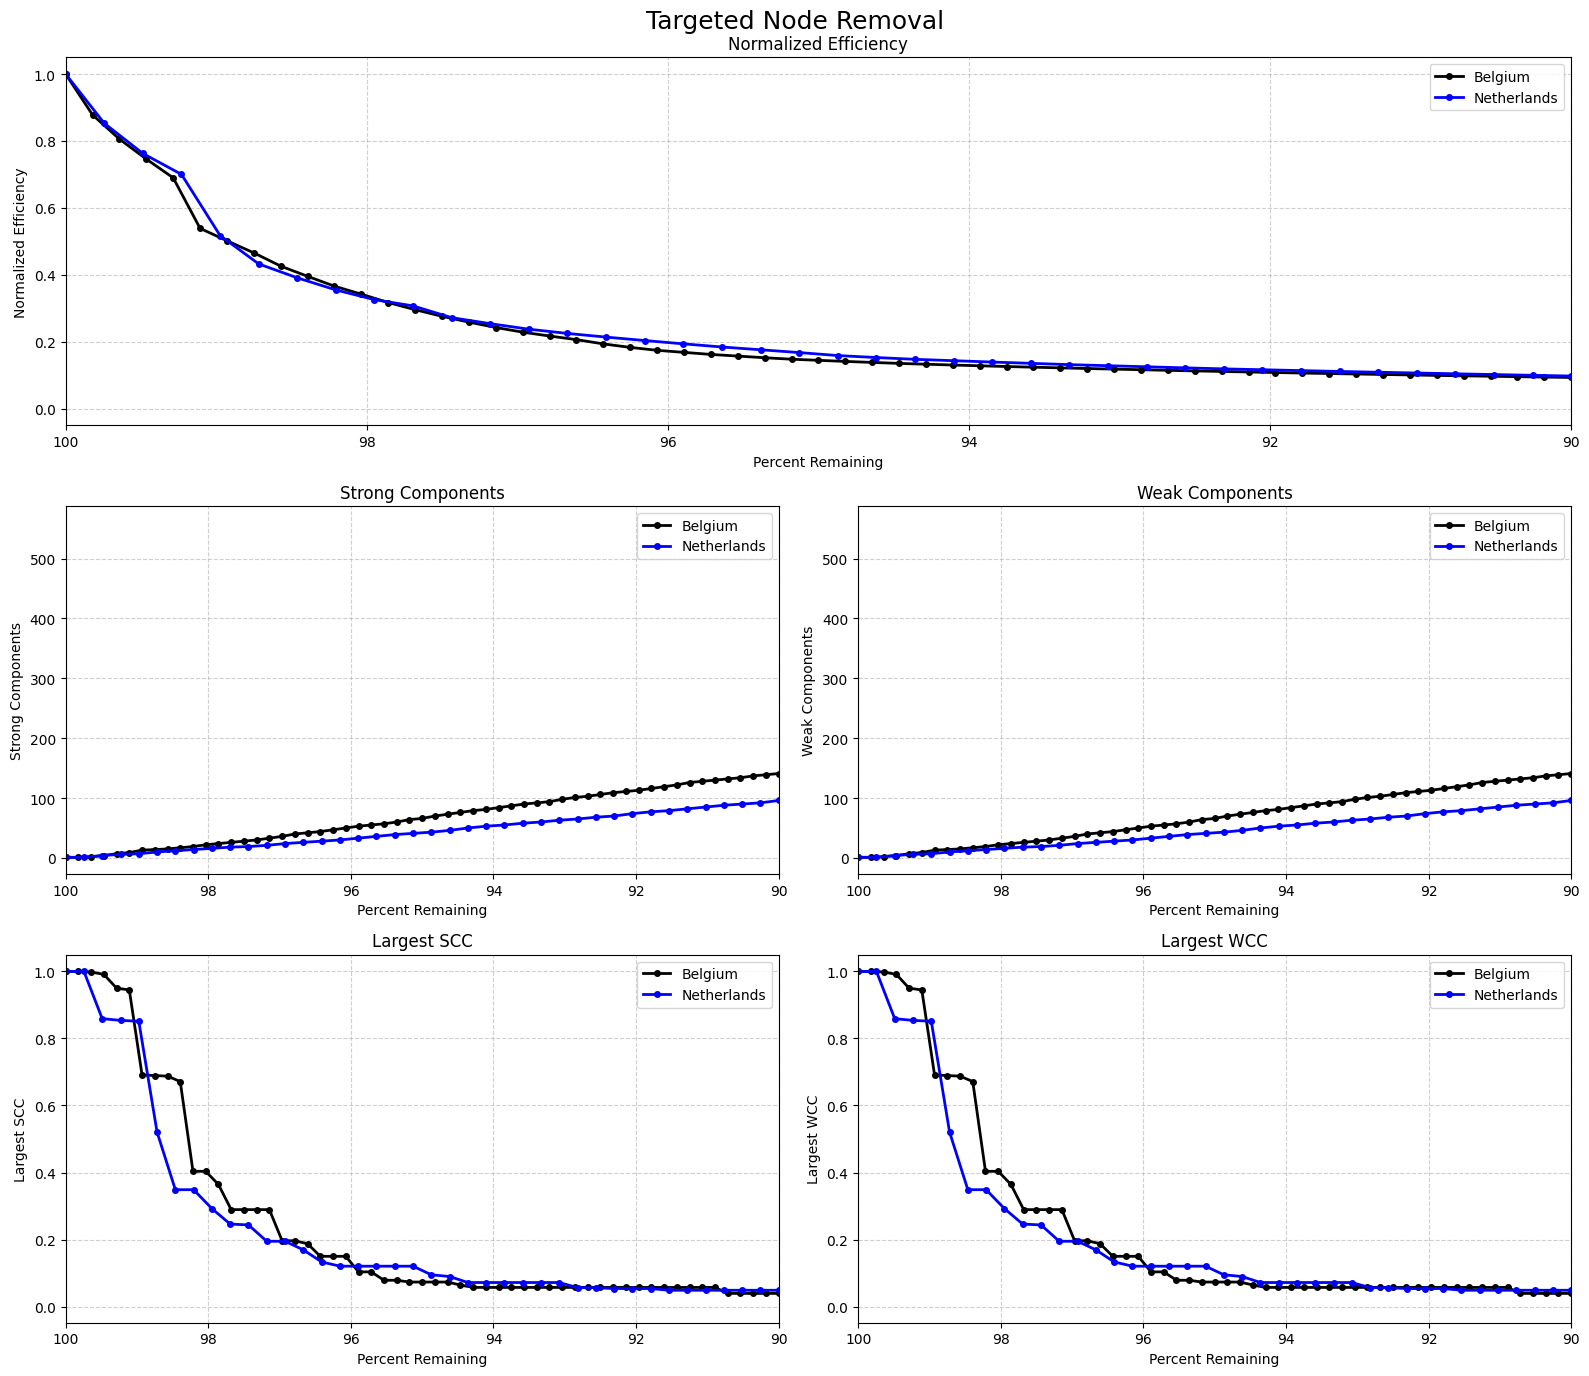

In [21]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_targeted_node_BE/targeted_removal_seed42_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_targeted_node_NL/targeted_removal_seed42_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Targeted Node Removal",
    xlim=(90,100)
)

### Betweenness Weighted

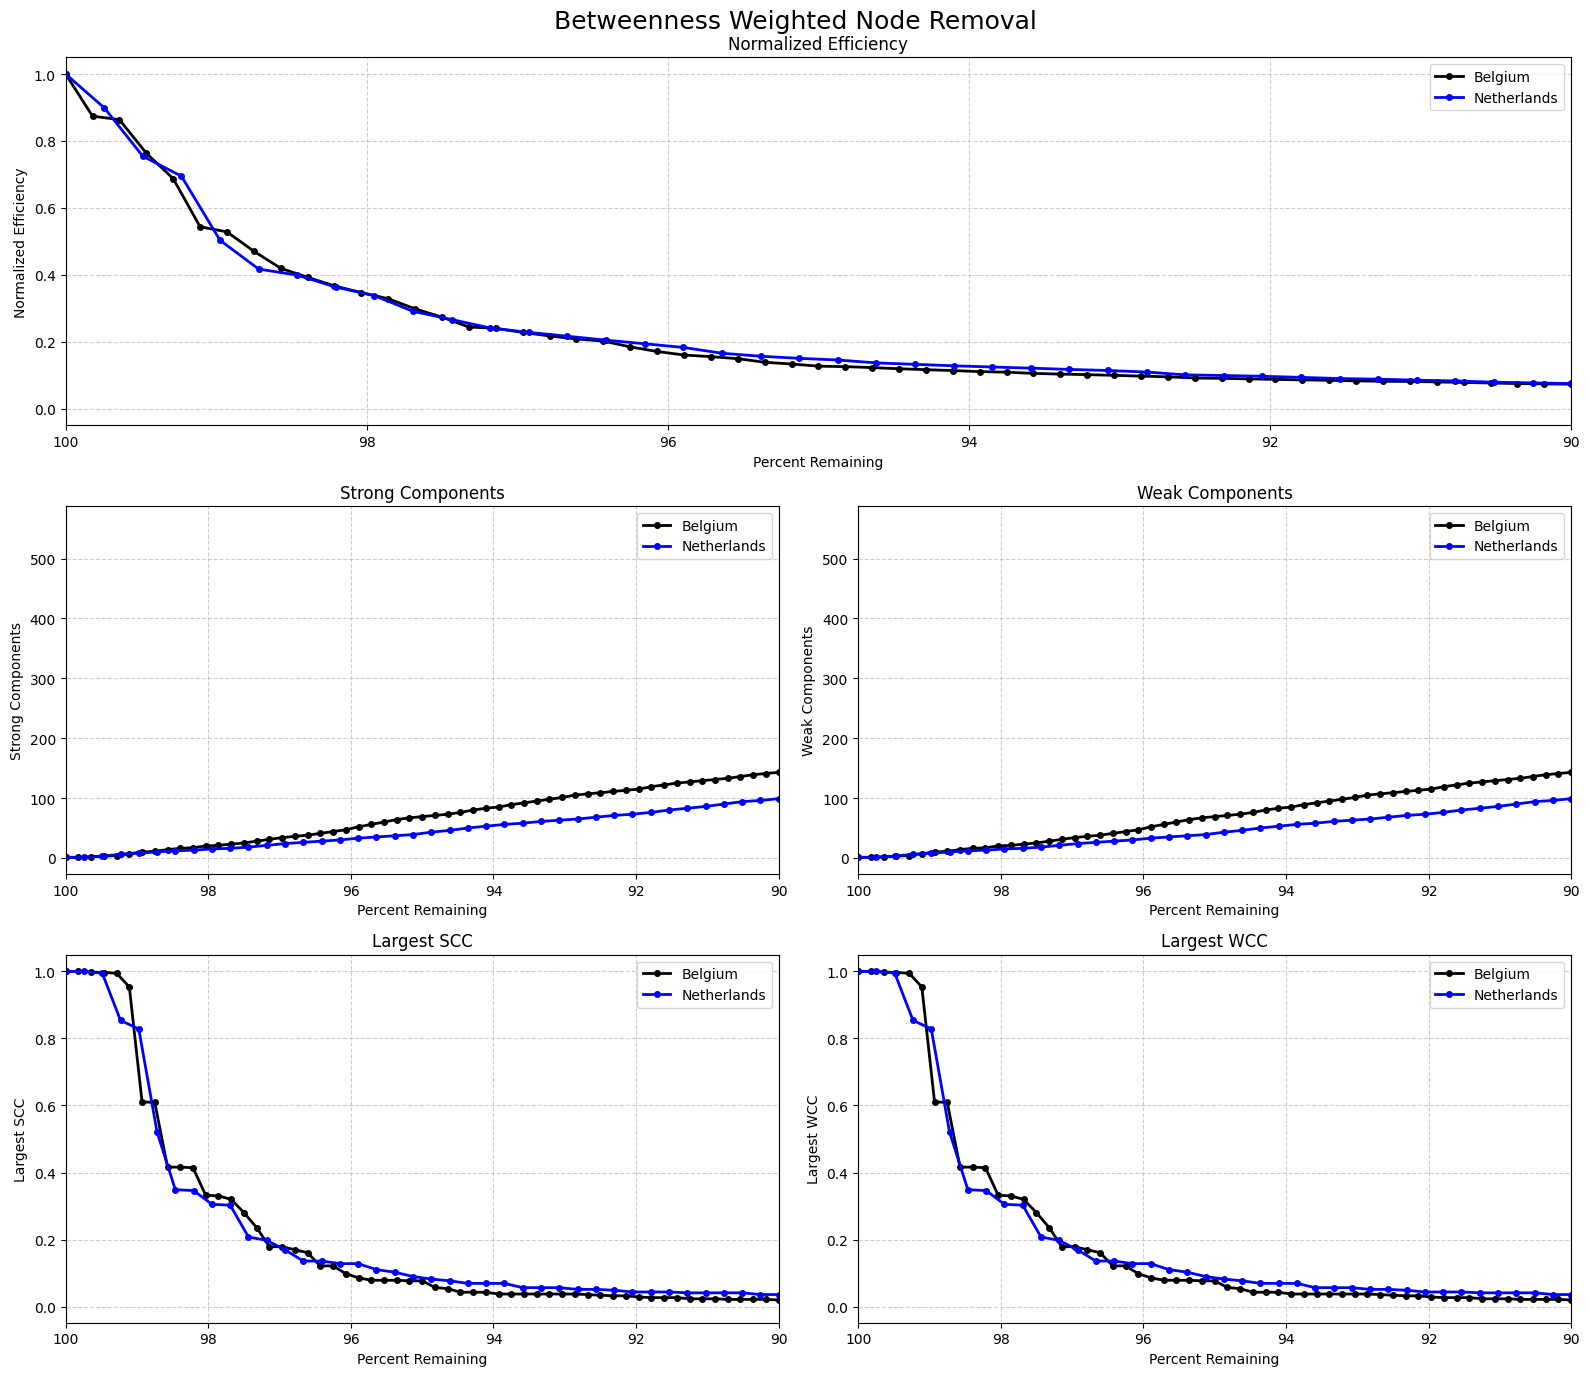

In [22]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_weighted_node_BE/betweenness_weighted_removal_seed42_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_weighted_node_NL/betweenness_weighted_removal_seed42_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Betweenness Weighted Node Removal",
    xlim=(90, 100)
)

### Betweenness Weighted Least

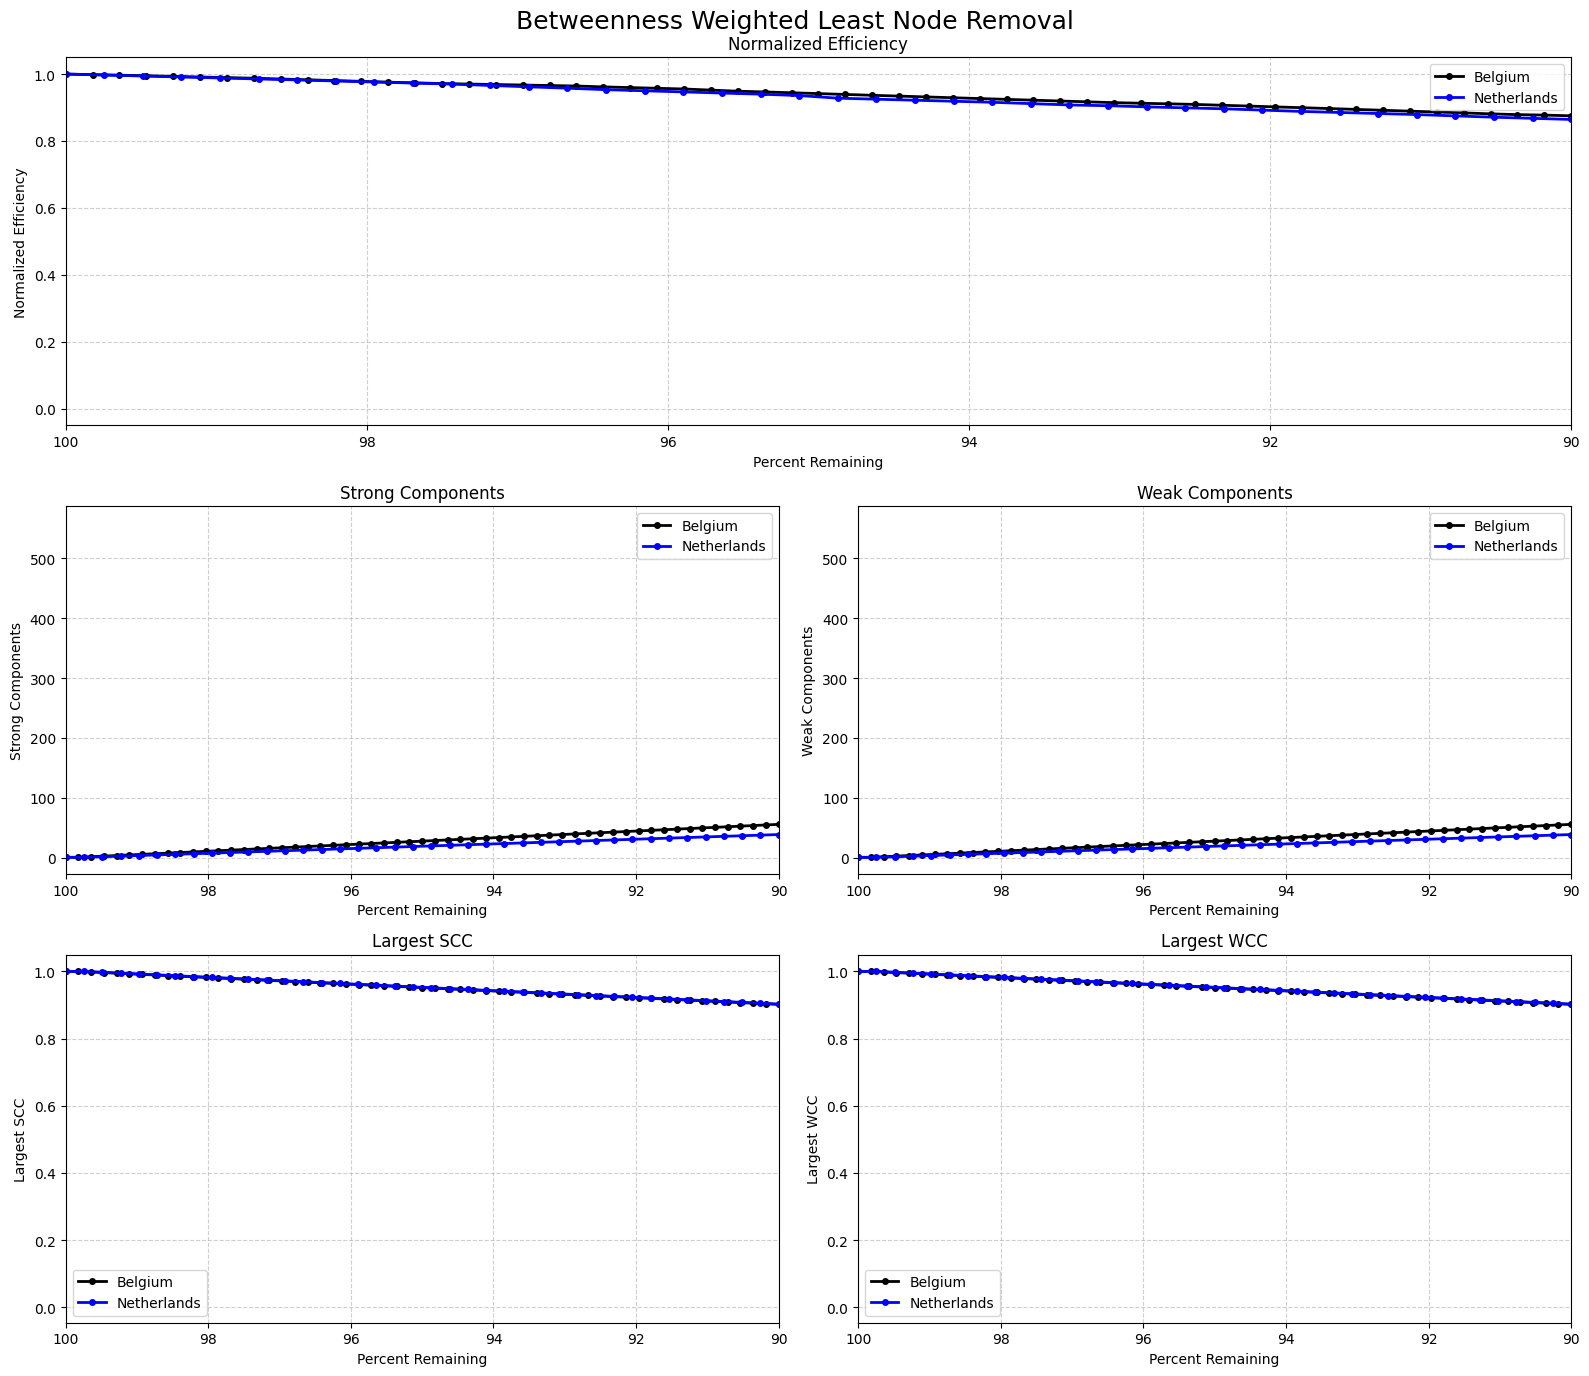

In [23]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_weighted_least_node_BE/betweenness_weighted_least_removal_seed42_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_weighted_least_node_NL/betweenness_weighted_least_removal_seed42_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Betweenness Weighted Least Node Removal",
    xlim=(90, 100)
)

### Betweennees Unweighted

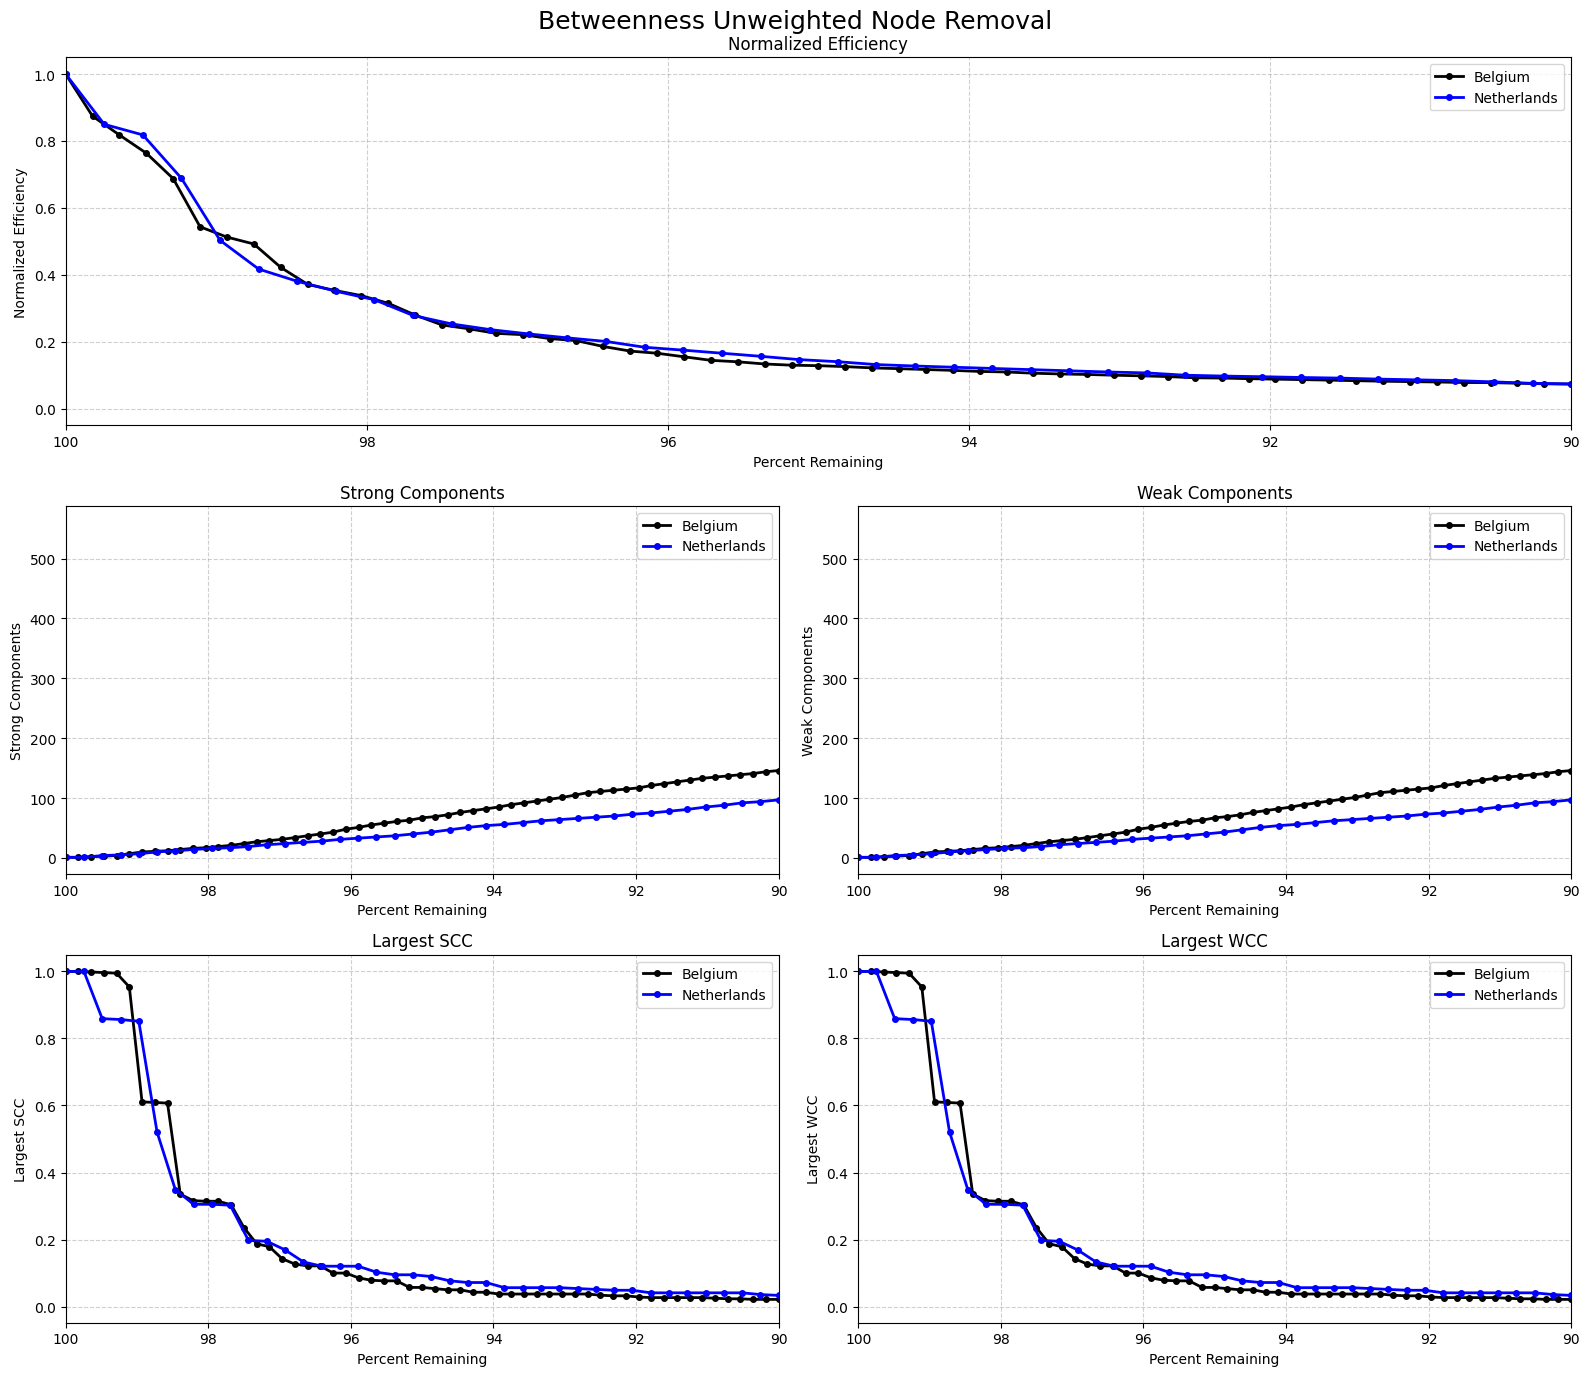

In [20]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_unweighted_node_BE/betweenness_unweighted_removal_seed42_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_unweighted_node_NL/betweenness_unweighted_removal_seed42_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Betweenness Unweighted Node Removal",
    xlim=(90, 100)
)

### Betweenneess Unweighted Least

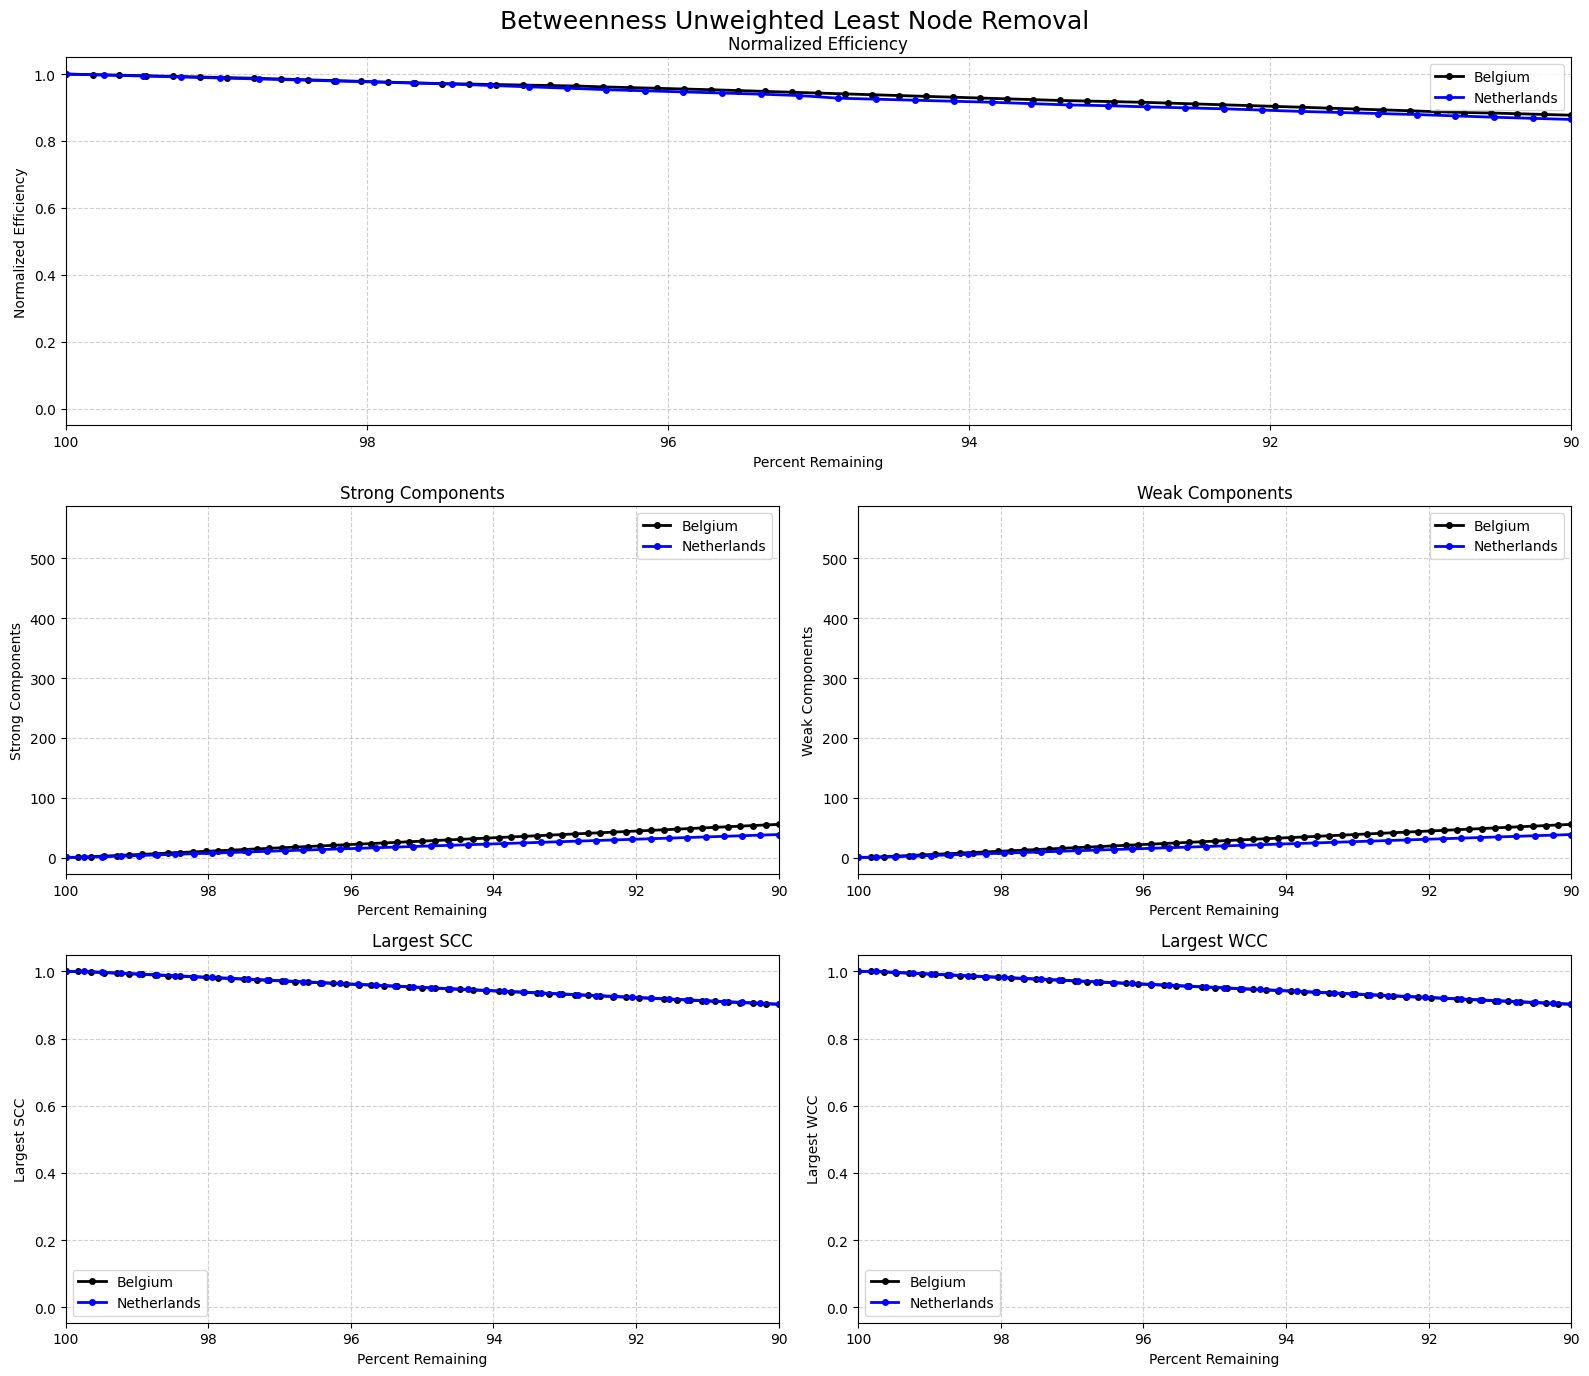

In [19]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_unweighted_least_node_BE/betweenness_unweighted_least_removal_seed42_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_betweenness_unweighted_least_node_NL/betweenness_unweighted_least_removal_seed42_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Betweenness Unweighted Least Node Removal",
    xlim=(90, 100)
)

### Top Hubs (Connections)

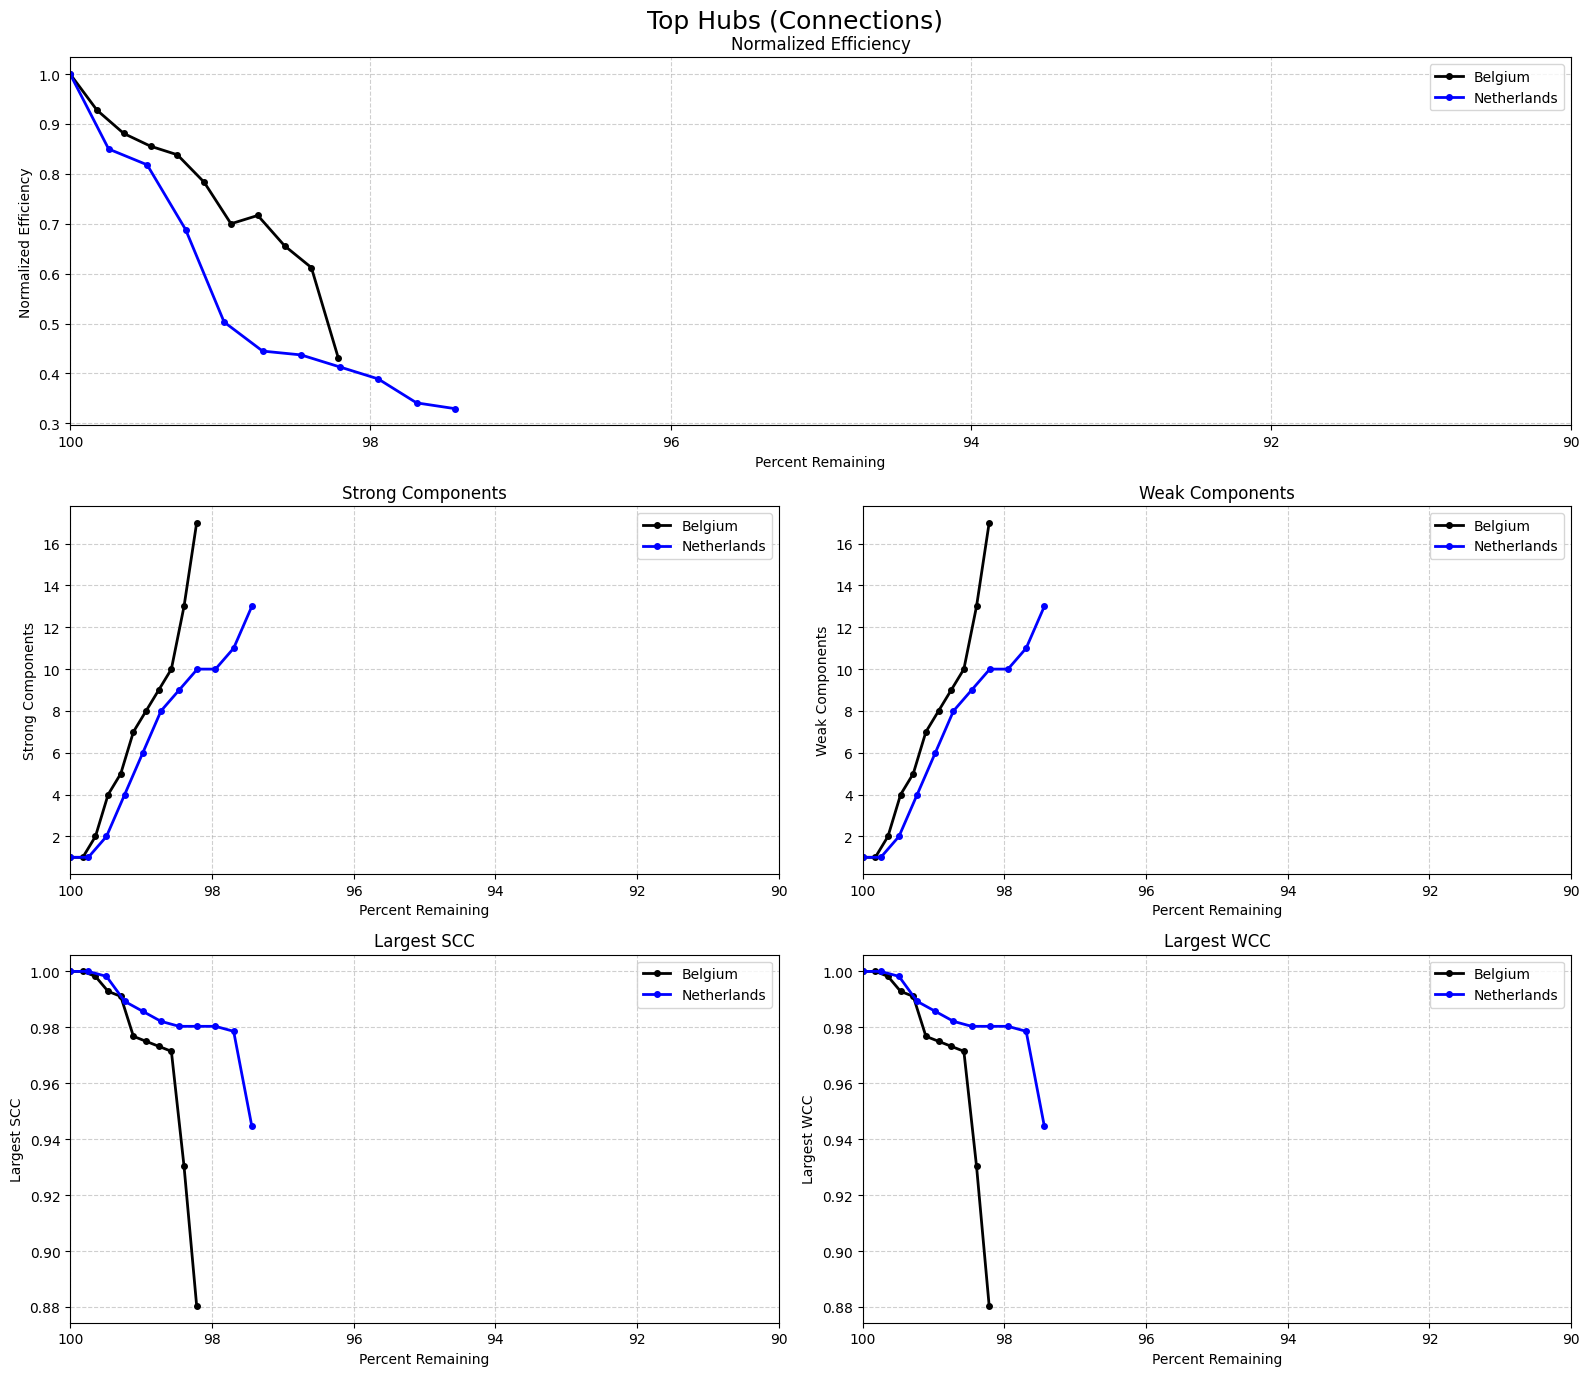

In [20]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_tophubs_node_BE/tophub_removal_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_tophubs_node_NL/tophub_removal_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Top Hubs (Connections)",
    xlim=(90, 100)
)

### Top Hubs (Train Frequency)

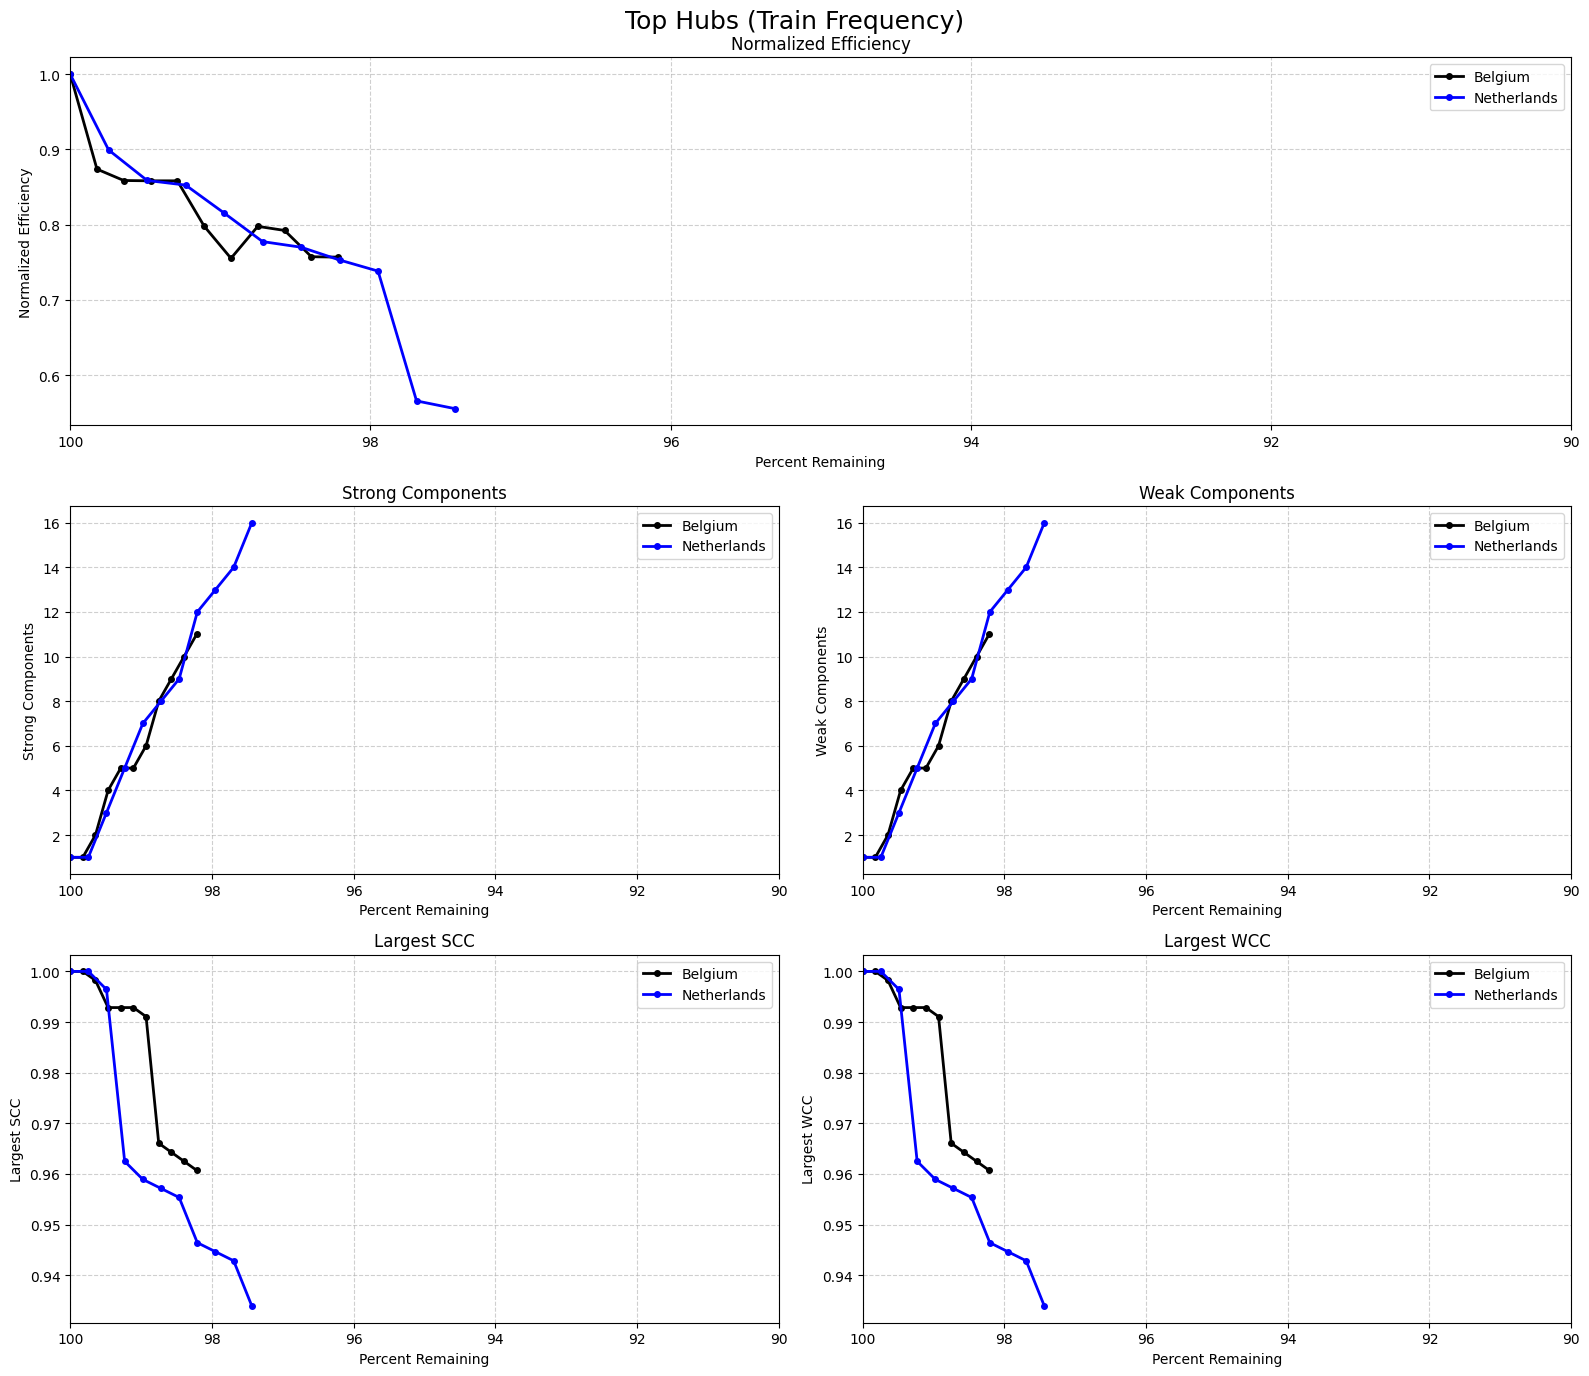

In [21]:
run_configs = [
    {
        'fil': DATA_DIR / "results/removal_runs_tophubs_trains_BE/tophub_removal_nodes560.csv",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/removal_runs_tophubs_trains_NL/tophub_removal_nodes390.csv",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Top Hubs (Train Frequency)",
    xlim=(90, 100)
)

## Edges

In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- Load graphs explicitly ---
L_graph_BE = load_graph(L_SPACE_PATH)
L_graph_NL = load_graph(DATA_DIR / "pkl/nl_merged.pkl")


def compute_connectivity_metrics_edges(df, G):
    """
    Compute SCC, WCC, largest SCC, and largest WCC as edges are progressively removed.
    G: directed graph (copy will be made internally)
    df must contain a column: 'removed_edge' with tuples (u, v)
    """
    G = G.copy()
    N = G.number_of_nodes()

    num_scc = []
    num_wcc = []
    largest_scc_norm = []
    largest_wcc_norm = []

    for _, row in df.iterrows():

        # before removal
        num_scc.append(nx.number_strongly_connected_components(G))
        num_wcc.append(nx.number_weakly_connected_components(G))

        # Largest SCC
        sccs = nx.strongly_connected_components(G)
        largest_scc = max((len(c) for c in sccs), default=0)
        largest_scc_norm.append(largest_scc / N)

        # Largest WCC
        wccs = nx.weakly_connected_components(G)
        largest_wcc = max((len(c) for c in wccs), default=0)
        largest_wcc_norm.append(largest_wcc / N)

        # Remove the edge
        edge = row['removed_edge']
        if pd.notna(edge):
            if isinstance(edge, str):
                # if saved as string "(u, v)"
                edge = eval(edge)
            u, v = edge
            if G.has_edge(u, v):
                G.remove_edge(u, v)

    df['num_strong_components'] = num_scc
    df['num_weak_components'] = num_wcc
    df['largest_scc_normalized'] = largest_scc_norm
    df['largest_wcc_normalized'] = largest_wcc_norm

    return df


def plot_efficiency_comparison_single_edges(run_configs, title="Efficiency Comparison", xlim=None):
    """
    Plot normalized efficiency and connectivity metrics for multiple edge-removal runs.

    run_configs: list of dicts:
        'fil'   -> path to CSV
        'color' -> color for plotting
        'label' -> Belgium or Netherlands
    """
    plt.figure(figsize=(16, 14))

    metrics = [
        ('normalized_efficiency', 'Normalized Efficiency'),
        ('num_strong_components', 'Strong Components'),
        ('num_weak_components', 'Weak Components'),
        ('largest_scc_normalized', 'Largest SCC'),
        ('largest_wcc_normalized', 'Largest WCC')
    ]

    processed_runs = []

    for cfg in run_configs:
        df = load_removal_results_df(cfg['fil'])

        # select graph
        if cfg['label'] == 'Belgium':
            graph = L_graph_BE
        elif cfg['label'] == 'Netherlands':
            graph = L_graph_NL
        else:
            raise ValueError(f"Unknown label {cfg['label']}")

        df = compute_connectivity_metrics_edges(df, graph)
        processed_runs.append((df, cfg['color'], cfg['label']))

    # First full-width plot
    plt.subplot(3, 2, (1, 2))
    col, ttl = metrics[0]
    for df, color, label in processed_runs:
        plt.plot(df['percent_remaining'], df[col], 'o-', linewidth=2, markersize=4, color=color, label=label)
    plt.title(ttl)
    plt.xlabel('Percent Remaining')
    plt.ylabel(ttl)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if xlim: plt.xlim(xlim)
    plt.gca().invert_xaxis()

    # Remaining 4 subplots
    for i, (col, ttl) in enumerate(metrics[1:], start=3):
        plt.subplot(3, 2, i)
        for df, color, label in processed_runs:
            plt.plot(df['percent_remaining'], df[col], 'o-', linewidth=2, markersize=4, color=color, label=label)
        plt.title(ttl)
        plt.xlabel('Percent Remaining')
        plt.ylabel(ttl)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        if xlim: plt.xlim(xlim)
        plt.gca().invert_xaxis()

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()


In [ ]:
run_configs = [
    {
        'fil': DATA_DIR / "results/",
        'color': 'black',
        'label': 'Belgium'
    },
    {
        'fil': DATA_DIR / "results/",
        'color': 'blue',
        'label': 'Netherlands'
    }
]

plot_efficiency_comparison_single(
    run_configs,
    title="Targeted Edge Removal",
    xlim=(90,100)
)

## Testing Stuff

In [10]:
# results_path = DATA_DIR / "results/removal_runs_targeted_node_BE/targeted_removal_seed42_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_targeted_node_NL/targeted_removal_seed42_nodes390.csv"

# results_path = DATA_DIR / "results/removal_runs_betweenness_weighted_node_BE/betweenness_weighted_removal_seed42_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_betweenness_weighted_node_NL/betweenness_weighted_removal_seed42_nodes390.csv"

results_path = DATA_DIR / "results/removal_runs_betweenness_weighted_least_node_BE/betweenness_weighted_least_removal_seed42_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_betweenness_weighted_least_node_NL/betweenness_weighted_least_removal_seed42_nodes390.csv"

# results_path = DATA_DIR / "results/removal_runs_betweenness_unweighted_node_BE/betweenness_unweighted_removal_seed42_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_betweenness_unweighted_node_NL/betweenness_unweighted_removal_seed42_nodes390.csv"

# results_path = DATA_DIR / "results/removal_runs_betweenness_unweighted_least_node_BE/betweenness_unweighted_least_removal_seed42_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_betweenness_unweighted_least_node_NL/betweenness_unweighted_least_removal_seed42_nodes390.csv"

# results_path = DATA_DIR / "results/removal_runs_tophubs_node_BE/tophub_removal_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_tophubs_node_NL/tophub_removal_nodes390.csv"

# results_path = DATA_DIR / "results/removal_runs_tophubs_trains_BE/tophub_removal_nodes560.csv"
# results_path = DATA_DIR / "results/removal_runs_tophubs_trains_NL/tophub_removal_nodes390.csv"

df = load_removal_results_df(results_path)

In [11]:
import networkx as nx
import pandas as pd

G = L_graph.copy()
N = G.number_of_nodes()

num_strong_components = []
num_weak_components = []
largest_scc_normalized = []
largest_wcc_normalized = []

for _, row in df.iterrows():

    # Strong and weak component counts BEFORE removal
    num_strong_components.append(nx.number_strongly_connected_components(G))
    num_weak_components.append(nx.number_weakly_connected_components(G))

    # Largest SCC
    sccs = nx.strongly_connected_components(G)
    largest_scc = max((len(c) for c in sccs), default=0)
    largest_scc_normalized.append(largest_scc / N)

    # Largest WCC
    wccs = nx.weakly_connected_components(G)
    largest_wcc = max((len(c) for c in wccs), default=0)
    largest_wcc_normalized.append(largest_wcc / N)

    # Remove only edges of the node (keep the node)
    node = row['removed_node']
    if pd.notna(node):
        node = int(node)

        if node in G:

            # Remove all outgoing edges
            out_edges = list(G.out_edges(node))
            G.remove_edges_from(out_edges)

            # Remove all incoming edges
            in_edges = list(G.in_edges(node))
            G.remove_edges_from(in_edges)

# Store results
df['num_strong_components'] = num_strong_components
df['num_weak_components'] = num_weak_components
df['largest_scc_normalized'] = largest_scc_normalized
df['largest_wcc_normalized'] = largest_wcc_normalized

df

step  removed_node  normalized_efficiency  percent_remaining  \
0       0           NaN               1.000000         100.000000   
1       1           7.0               0.998369          99.821429   
2       2           6.0               0.996684          99.642857   
3       3           5.0               0.994908          99.464286   
4       4           4.0               0.993107          99.285714   
..    ...           ...                    ...                ...   
555   555         277.0               0.000414           0.892857   
556   556         286.0               0.000254           0.714286   
557   557         287.0               0.000130           0.535714   
558   558         288.0               0.000044           0.357143   
559   559         289.0               0.000000           0.178571   

     removal_time_seconds  num_strong_components  num_weak_components  \
0                  0.0000                      1                    1   
1                 17.1972                      1                    1   
2                 16.7443                      2                    2   
3                 16.6550                      3                    3   
4                 19.2523                      4                    4   
..                    ...                    ...                  ...   
555                0.3274                    555                  555   
556                0.3416                    556                  556   
557                0.2346                    557                  557   
558                0.3294                    558                  558   
559                0.3153                    559                  559   

     largest_scc_normalized  largest_wcc_normalized  
0                  1.000000                1.000000  
1                  1.000000                1.000000  
2                  0.998214                0.998214  
3                  0.996429                0.996429  
4                  0.994643                0.994643  
..                      ...                     ...  
555                0.010714                0.010714  
556                0.008929                0.008929  
557                0.007143                0.007143  
558                0.005357                0.005357  
559                0.003571                0.003571  

[560 rows x 9 columns]

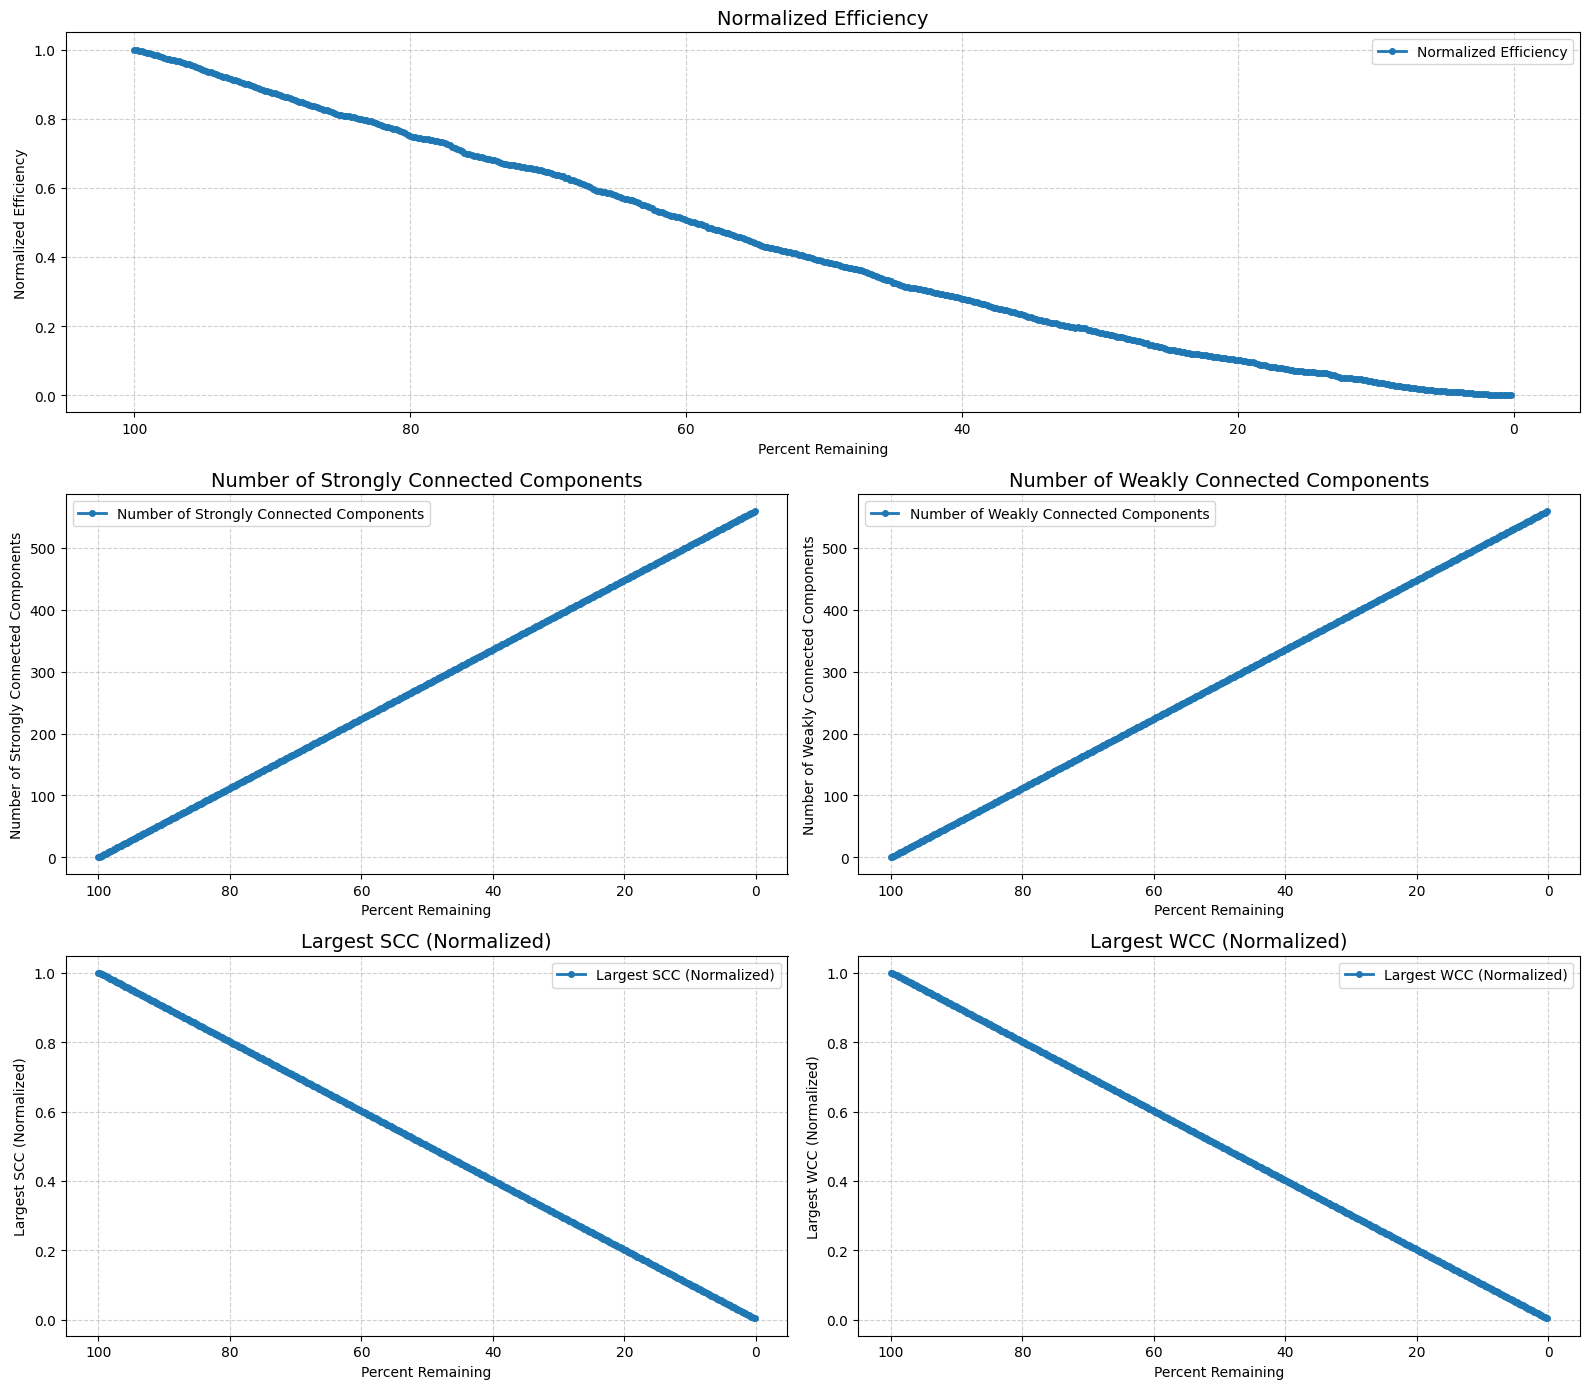

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))

metrics = [
    ('normalized_efficiency', 'Normalized Efficiency'),
    ('num_strong_components', 'Number of Strongly Connected Components'),
    ('num_weak_components', 'Number of Weakly Connected Components'),
    ('largest_scc_normalized', 'Largest SCC (Normalized)'),
    ('largest_wcc_normalized', 'Largest WCC (Normalized)')
]

# Plot 1 (full width)
plt.subplot(3, 2, (1, 2))
col, title = metrics[0]
plt.plot(df['percent_remaining'], df[col], 'o-', label=title, linewidth=2, markersize=4)
plt.title(title, fontsize=14)
plt.xlabel('Percent Remaining')
plt.ylabel(title)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.gca().invert_xaxis()   # invert the axis

# Plot 2x2 below
for i, (col, title) in enumerate(metrics[1:], start=3):
    plt.subplot(3, 2, i)
    plt.plot(df['percent_remaining'], df[col], 'o-', label=title, linewidth=2, markersize=4)
    plt.title(title, fontsize=14)
    plt.xlabel('Percent Remaining')
    plt.ylabel(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.gca().invert_xaxis()   # invert the axis

plt.tight_layout()
plt.show()